In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import *
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve
import scikitplot as skplt 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report,roc_auc_score,roc_curve
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("Telecom_Churn.xls")

# Q1

## Data Preprocessing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account Length  3333 non-null   int64  
 1   VMail Message   3333 non-null   int64  
 2   Day Mins        3333 non-null   float64
 3   Eve Mins        3333 non-null   float64
 4   Night Mins      3333 non-null   float64
 5   Intl Mins       3333 non-null   float64
 6   CustServ Calls  3333 non-null   int64  
 7   Churn           3333 non-null   int64  
 8   Int'l Plan      3333 non-null   int64  
 9   VMail Plan      3333 non-null   int64  
 10  Day Calls       3333 non-null   int64  
 11  Day Charge      3333 non-null   float64
 12  Eve Calls       3333 non-null   int64  
 13  Eve Charge      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Calls      3333 non-null   int64  
 17  Intl Charge     3333 non-null   f

In [4]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:",data.duplicated().sum())
print("Missing values:",data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


In [5]:
data.Churn.value_counts(normalize=True).mul(100)

0    85.508551
1    14.491449
Name: Churn, dtype: float64

## Feature Engineering

In [6]:
data= data.drop('Phone',axis =1)

In [8]:
data.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Int'l Plan,VMail Plan,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,110,45.07,99,16.78,91,11.01,3,2.70,KS,415
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,123,27.47,103,16.62,103,11.45,3,3.70,OH,415
2,137,0,243.4,121.2,162.6,12.2,0,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,NJ,415
3,84,0,299.4,61.9,196.9,6.6,2,0,1,0,71,50.90,88,5.26,89,8.86,7,1.78,OH,408
4,75,0,166.7,148.3,186.9,10.1,3,0,1,0,113,28.34,122,12.61,121,8.41,3,2.73,OK,415


In [9]:
data_num=data.select_dtypes(exclude="object")
data_obj=data.select_dtypes(include="object")

In [10]:
data_dummies=pd.get_dummies(data_obj,prefix=data_obj.columns,drop_first=True)

In [11]:
data_model=data_num.join(data_dummies)

In [14]:
# Train/Test split
X=data_model.drop('Churn', axis=1)
Y=data_model.Churn

In [15]:
X0, X1, Y0, Y1=train_test_split(X,Y, test_size=0.25, random_state=42)

In [16]:
# decision tree
dt=DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X0,Y0)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [17]:
Y0_dt=dt.predict_proba(X0)[:,1]
Y1_dt=dt.predict_proba(X1)[:,1]

In [18]:
print("ROC_AUC Train for Fully grown DT:",roc_auc_score(Y0,Y0_dt))
print("ROC_AUC Test for Fully grown DT:",roc_auc_score(Y1,Y1_dt))

ROC_AUC Train for Fully grown DT: 0.8373156176693916
ROC_AUC Test for Fully grown DT: 0.8265782792665726


## Q2

In [19]:
# Tuned Decision Tree using GridSearch on non - scaled data
param_dt={"max_depth":range(2,5),"min_samples_leaf":range(10,100,10),
          "class_weight":["balanced", None]}

gs_dt=GridSearchCV(estimator=dt,param_grid=param_dt,scoring="roc_auc",cv=5,n_jobs=-1)
gs_dt.fit(X0,Y0)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': range(2, 5),
                         'min_samples_leaf': range(10, 100, 10)},
             scoring='roc_auc')

In [20]:
best_params = gs_dt.best_params_
best_params

{'class_weight': None, 'max_depth': 4, 'min_samples_leaf': 30}

In [21]:
dt_grid=DecisionTreeClassifier(class_weight=best_params['class_weight'],max_depth=best_params['max_depth'],
                             min_samples_leaf=best_params['min_samples_leaf'], random_state=42).fit(X0,Y0)


Y0_dt_grid=dt_grid.predict_proba(X0)[:,1]
Y1_dt_grid=dt_grid.predict_proba(X1)[:,1]

In [22]:
print("ROC_AUC Train for Tuned DT:",roc_auc_score(Y0,Y0_dt_grid))
print("ROC_AUC Test for Tuned DT:",roc_auc_score(Y1,Y1_dt_grid))

ROC_AUC Train for Tuned DT: 0.8859491074760136
ROC_AUC Test for Tuned DT: 0.8915373765867418


In [23]:
threshold = 0.5
Y0_dt_class = np.where(Y0_dt_grid> threshold, 1, 0)
Y1_dt_class = np.where(Y1_dt_grid> threshold, 1, 0)

Calculate Sensitivity, Specificity, ROC AUC and any other measure you find appropriate for evaluating model performance and choose winner model.

In [24]:
cm_train = confusion_matrix(Y0, Y0_dt_class ).T

In [25]:
print("Accuracy_train:", (cm_train[0,0]+cm_train[1,1])/len(Y0))
print("Sensitivity_train:",cm_train[1,1]/(cm_train[1,1]+cm_train[0,1]))
print("Specificity_train:",cm_train[0,0]/(cm_train[0,0]+cm_train[1,0]))

Accuracy_train: 0.9243697478991597
Sensitivity_train: 0.5391061452513967
Specificity_train: 0.9887902849135918


In [26]:
#confusion matrix for the test data
cm_test=confusion_matrix(Y1,Y1_dt_class).T

In [27]:
print("Accuracy_test:", (cm_test[0,0]+cm_test[1,1])/len(Y1))
print("Sensitivity_test:",cm_test[1,1]/(cm_test[1,1]+cm_test[0,1]))
print("Specificity_test:",cm_test[0,0]/(cm_test[0,0]+cm_test[1,0]))

Accuracy_test: 0.9124700239808153
Sensitivity_test: 0.496
Specificity_test: 0.9858956276445698


Based on the results it is apparent that the model derived from grid-search has better performance, because it has small overfitting and significantly higher test roc-auc.

## Feature importance

In [28]:
#making a dataframe for convenient usage
feat_imp=pd.DataFrame(dt_grid.feature_importances_,index=X.columns,
                      columns=["Feature_imp"])
feat_imp=feat_imp.sort_values(by="Feature_imp",ascending=False)
feat_imp.head(10)

,Feature_imp
Day Charge,0.372407
CustServ Calls,0.211847
Int'l Plan,0.127461
Intl Calls,0.111719
Eve Charge,0.083200
VMail Plan,0.081840
Day Calls,0.006561
Night Mins,0.004965
Account Length,0.000000
State_NY,0.000000


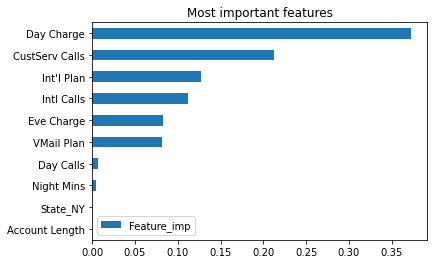

In [29]:
feat_imp.head(10).sort_values('Feature_imp').plot.barh()
plt.title("Most important features")
plt.show()

The most important features are 'Day Change', 'CustServ Calls', and 'Int'l Plan'. 

### Best Logit model from HW 3

- ROC_AUC Train: 0.819228459302592
- ROC_AUC Test: 0.8281670923276073

Best on the results from the HW 3's best logit model, we can see that out current best decision tree outperforms logit as well, because in has significantly higher test roc-auc score. 

# Q3

## Gain and Lift charts 

In [30]:
FPR,TPR,thresholds=roc_curve(Y1,Y1_dt_grid)

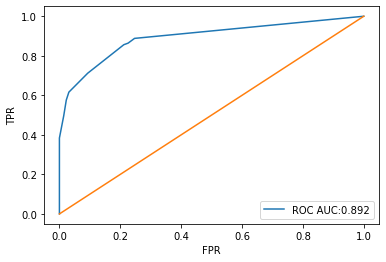

In [31]:
plt.plot(FPR,TPR,label=f"ROC AUC:{roc_auc_score(Y1,dt_grid.predict_proba(X1)[:,1]).round(3)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

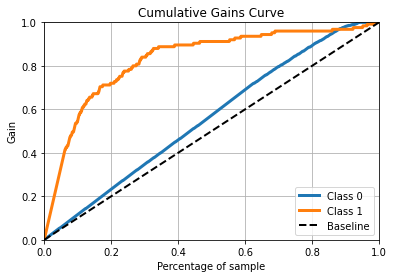

In [32]:
skplt.metrics.plot_cumulative_gain(Y1,dt_grid.predict_proba(X1))
plt.show()

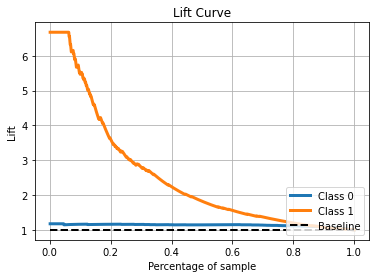

In [33]:
skplt.metrics.plot_lift_curve(Y1,dt_grid.predict_proba(X1))
plt.show()